## Notebook documenting functionality of models developed in [biorxiv link] 

Running these functions requires the following dependencies:
- moments ([https://bioconda.github.io/recipes/moments/README.html](https://bioconda.github.io/recipes/moments/README.html)) 
- numpy
- scipy
- matplotlib

In [46]:
# numerics + rv stuff
import numpy as np
from numpy.random import default_rng
import scipy as sp

import moments

# plotting + misc tools
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import os

# method of moments framework + helper functions
from mom_functions import *

# rng setup
rng = default_rng(82020)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

### Introducing the age conditioned SFS (acSFS)

In standard notation, the expected SFS is given by $\Phi_{2n}$ for a diploid sample of size $n$. This quantity is, typically, of size $2n+1$, where the $0^{th}$ and $2n^{th}$ entries represent the lost and fixed bins, respectively. 

The acSFS represents the expected number of sites present at sample frequency $i$, conditional on having arisen $a$ generations ago. For a diploid sample of size $n$, we denote acSFS in the present-day (generation $0$) for alleles that arose $a$ generation ago as $\Phi^{0\mid a}_{2n}$. Thus, $\Phi^{0\mid a}_{2n}(i)$ gives the expected number of alleles $a$ generations old that are found at frequency $i$ in a diploid sample of size $n$. Below, in code, we use a matrix that contains a stack of these acSFS for easy indexing and storage, so this quantity is of size $A_{\mathrm{max}} \times (2n+1)$, where $A_{\mathrm{max}}$ is the largest number of generations we run the algorithm to. In this matrix, the $a^{th}$ row consists of the acSFS for alleles that are $a$ generations old. 

Below is code on how to compute the acSFS for a given constant population size $(N=10,000)$, population scaled selection coefficient $(\gamma = -10\ \mathrm{or}\  s = -5\times 10^{-4})$ across $100,000$ generations with a constant population scaled mutation rate $(\theta=200)$. 

(As a check, a scatter plot showing that the acSFS marginalized across all generations from $1$ to some large $A_{\mathrm{max}}$ yields the equilbirium SFS from $\texttt{moments}$, as expected.)

(30000, 201)


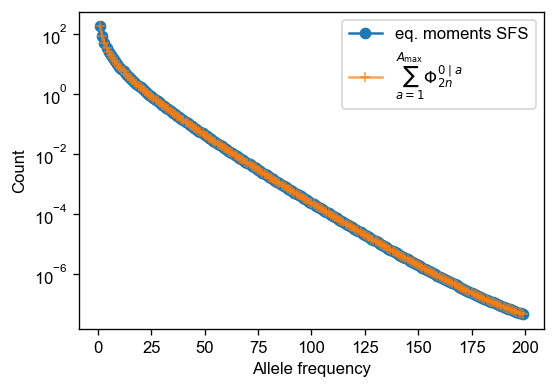

In [47]:
# population parameters
N = 10000
gamma = -10
theta = 200

# sample size
twon = 200 

# computing the equilibrium SFS under the population parameters using moments
sfs = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(2000, gamma=gamma, theta=theta))
sfs = sfs.project([twon])

# computing the stack of acSFS for the same population parameters
## (we invert the acSFS for easy indexing, so row $a$ contains the acSFS for alleles that are $a$ generations old)
acsfs = run_mom_iterate_constant(Amax=30000, twon=twon, s=gamma/N, N=N, theta=theta)[::-1]
print(acsfs.shape)

# showing that the sum of the acSFS across all generations yields the equilibrium SFS from moments
plt.figure(dpi=120)
plt.plot(range(1,twon), sfs[1:-1], '-o', linewidth=1.5, label='eq. moments SFS'); plt.semilogy(); plt.xlabel('Allele frequency'); plt.ylabel('Count')
plt.plot(range(1,twon), acsfs.sum(axis=0)[1:-1], '-+', linewidth=1.5, alpha=0.7, label=r'$\sum_{a=1}^{A_\mathrm{max}} \Phi^{0\mid a}_{2n}$'); plt.legend(); 

### Visualizing the acSFS

We can now visualize and summarize properties of the acSFS below:
- $P(a \mid \gamma, n)$ which is the probability density on age conditional on a particular selection coefficient and sample size (i.e., conditional on segregation)
- $P(a \mid i, \gamma, n)$ which is the probability density on age conditional on a segregating sample frequency $i$ in the present

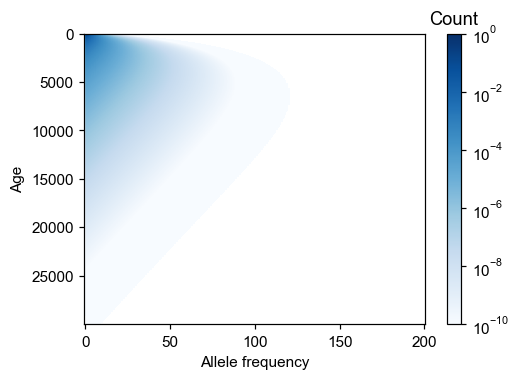

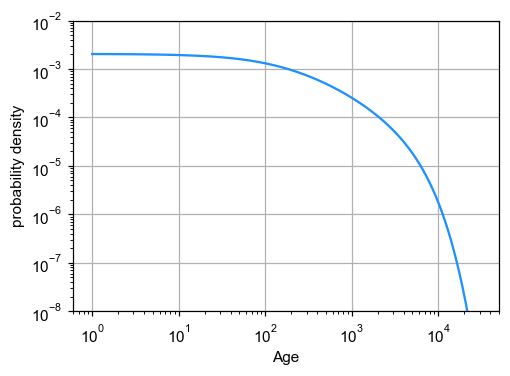

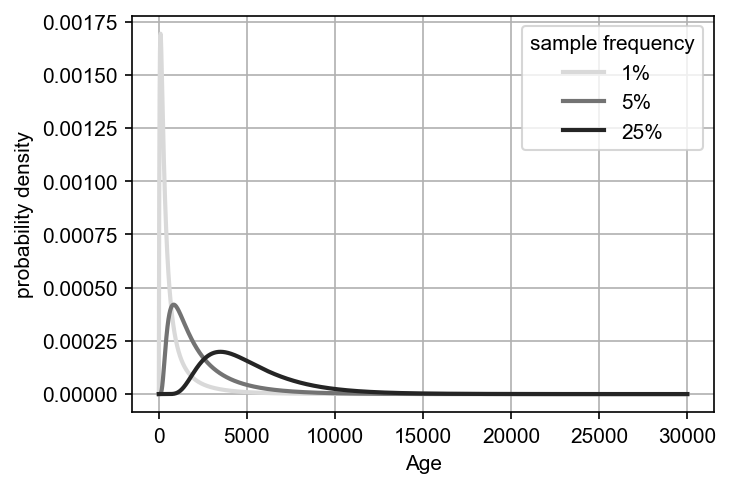

In [49]:
# visualizing the stack of acSFS
plt.imshow(acsfs, cmap='Blues', aspect='auto', norm=colors.LogNorm(vmin=1e-10)); cbar = plt.colorbar(); cbar.ax.set_title('Count') 
plt.xlabel('Allele frequency'); plt.ylabel(r'Age'); plt.show()

# visualizing the distribution on age conditional on segregation
plt.plot(range(1,acsfs.shape[0]+1), acsfs.sum(axis=1)/acsfs.sum(), color='dodgerblue'); plt.xlabel('Age'); plt.ylabel('probability density')
plt.loglog(); plt.ylim((1e-8, 1e-2)); plt.grid(); plt.show()

# sample frequency of 1%, 5%, 25%
i = [0.01, 0.05, 0.25]
gcols = ['#d9d9d9','#737373','#252525']
plt.figure(dpi=120)
for idx, i in enumerate(i):
    plt.plot(range(1,acsfs.shape[0]+1), acsfs[:,int(i*twon)]/acsfs[:,int(i*twon)].sum(), linewidth=2, color=gcols[idx], label='{:d}%'.format(int(i*100)))
plt.xlabel('Age'); plt.ylabel('probability density'); plt.legend(title='sample frequency'); plt.grid()

## Similarly for changing population sizes...